In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly
from fbprophet import Prophet as proph
import pickle
import joblib

In [7]:
na_value=['',' ','nan','Nan','NaN','na']
train=pd.read_csv('./train.csv',na_values=na_value)
store=pd.read_csv('./store.csv',na_values=na_value)
test=pd.read_csv('./test.csv',na_values=na_value)

In [8]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)
test.fillna(value = 1, inplace = True)

In [9]:
#merge the dataset
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [10]:
train[(train.Open != 0)&(train.Sales >0)]
train=train[['Date','Sales']]

In [12]:
train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format=True)

In [19]:
train.Date.nsmallest()

941    2013-01-01
1883   2013-01-01
2825   2013-01-01
3767   2013-01-01
4709   2013-01-01
Name: Date, dtype: datetime64[ns]

In [13]:
#function to remove any negative forecasted values.
def remove_negs(ts):
    ts['yhat'] = ts['yhat'].clip_lower(0)
    ts['yhat_lower'] = ts['yhat_lower'].clip_lower(0)
    ts['yhat_upper'] = ts['yhat_upper'].clip_lower(0)

In [20]:
#dataframe of annual US Public Holidays + 2017 Presidential Inauguration over training and forecasting periods 

ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2013-01-01', '2014-01-01','2015-01-01'])})  
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2015-11-26', '2016-11-24'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2015-12-25', '2016-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny,thanks, christ, inaug])

In [27]:
train.columns = ['ds', 'y']
train['y'].apply('float32')
train1=train.sample(1000) #To avoid Memory error

In [31]:
#0.9 *len(train)
m = proph(yearly_seasonality=True, holidays=us_public_holidays)
m.fit(train1)
future = m.make_future_dataframe(periods=31+28, freq='D', include_history=True)
forecast_1 = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


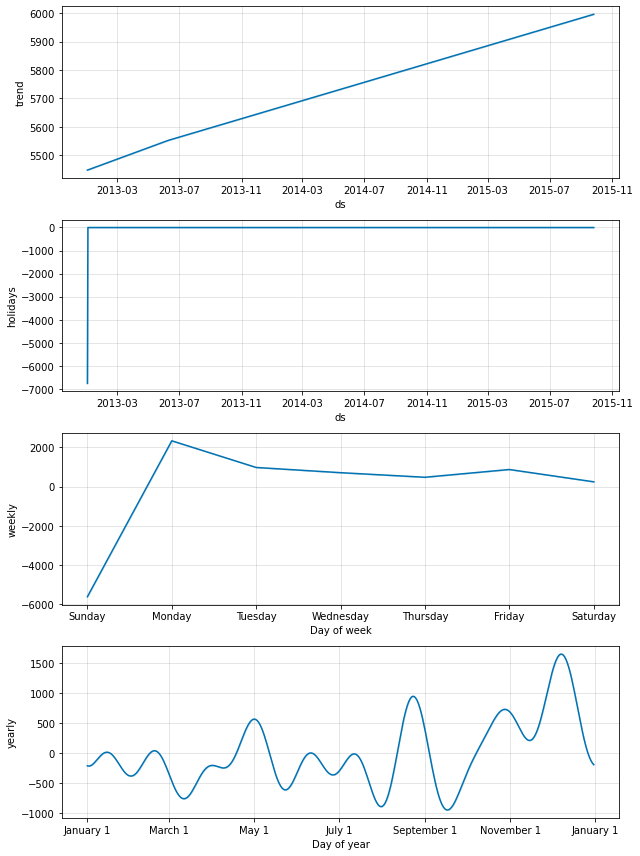

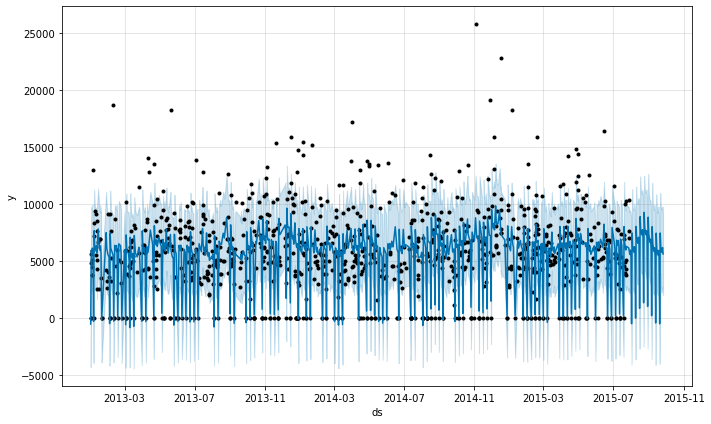

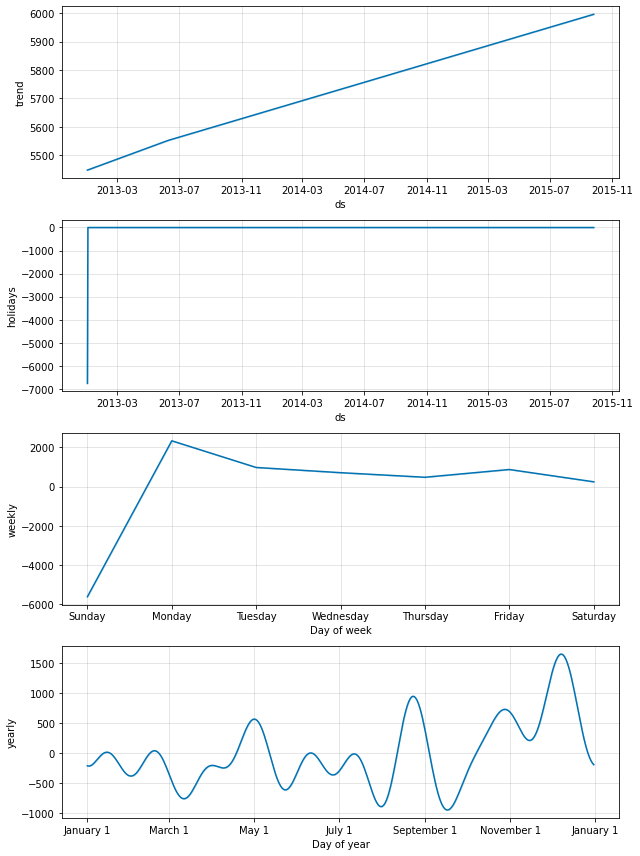

In [33]:
#remove_negs(forecast_1)
#plot forecasted values and components 
m.plot(forecast_1)
m.plot_components(forecast_1)

In [36]:
pickle.dump(m, open('p23-08-2020-10-42-31-00.pkl','wb'))

In [39]:
# To dump
f = './p23-08-2020-4-24-31-00.joblib'
joblib.dump(m,  f + '.bz2', compress=('bz2', 3))

['./p23-08-2020-4-24-31-00.joblib.bz2']

In [41]:
#m is the loaded prophet model
#@app.route("/*/api/v1.0/*/*", methods=['POST'])
def predict():
    inp = int(request.json['inp'])
    
    future2 = m.make_future_dataframe(periods=inp)
    forecast2 = m.predict(future2)
    
    data = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-horizon:]
    
    ret = data.to_json(orient='records', date_format='iso')
    
    return ret